# This Tutorial Will Demonstrate How to Use Pyradiomics on MRI Data to Identify Glioblastoma Tumor Genotype

## 1.1 Import and Reformat Data

The Pyradiomics features file has already been generated for you and is called "radiomics_features.csv". There is a separate file called "UCSF_PDGM_metadata_v2.csv", which provides the tumor genotype, and some other demographics information for each glioblatoma patient. You will first merge these csv files on the patient ID and then continue to organize the data. See the comments in the code for more details on each step.

In [1]:
import pandas as pd
import numpy as np
# Reads in the patient and image feature data
rad_df = pd.read_csv('radiomic_features_T1gad_bias.csv')
rad_df = rad_df.drop(['Image', 'Mask', 'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',    
       'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 
       'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VolumeNum',
       'diagnostics_Mask-original_CenterOfMassIndex', 
       'diagnostics_Mask-original_CenterOfMass'], axis=1)

# dataset with IDH status
med_df = pd.read_csv('UCSF-PDGM-metadata_v2.csv')

# Merges the two dataframes on the ID column
data = med_df.merge(rad_df, how='outer', on='ID')

# Modifies the IDH column (the value we are trying to predict)
# to a 1 for IDH Mutated or 0 for IDH wildtype
data.loc[data.IDH != 'wildtype', 'IDH'] = 1
data.loc[data.IDH == 'wildtype', 'IDH'] = 0

# Binarizes the Sex Values into 1's and 0's
# data["Sex"] = np.where(data["Sex"] == "F", 0, 1)

# Removes columns that either don't have radiomic features or contain info
# our model can use to cheat in making it's predictions
# For example 1p/19q is another genotype that is closely associated with
# IDH mutations. Similarly, WHO CNS Grade gives
# information about IDH staus. (Keeps the IDH column so it can be assigned to y later)
data = data.drop(['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 
                  'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index', 
                  '1p/19q', '1-dead 0-alive', 'OS', 'EOR', 'Biopsy prior to imaging', 
                  'BraTS21 ID', 'BraTS21 Segmentation Cohort','BraTS21 MGMT Cohort'], 
                   axis=1) 

## 1.2 Build the Training and Testing Datasets

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# defines our predicted classes (1 = IDH mutated; 2 = IDH Wildtype)
y = data['IDH']
y_array = np.array(y)
y_array = y_array.astype('int')

# Drop prediction value and non-image features. Our model will 
# use only imaging features
data = data.drop(['IDH'], axis=1)
X = data
X_array = np.array(X)

# Scale the data from 0 to 1 based on maximum 
# and minimum values in the dataset
scaler = MinMaxScaler()
scaler.fit(X_array)
X_array = scaler.transform(X_array)

# Randomly divide X and y into training and test sets so that you have 20
# % of the data used as a testet. Random state generates a "random" split
# of the data that can be replicated in future versions of testing
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, 
                                   test_size=0.20, random_state=0)

## 1.3 Determine IDH Class Proportions

In [3]:
# Determine the ratio of IDH mutated to IDH wildtype in the dataset
print("Percent IDH mutated: ", sum(y)/len(y))
print("Percent IDH wildtype: ", (len(y)-sum(y))/len(y))

Percent IDH mutated:  0.2055888223552894
Percent IDH wildtype:  0.7944111776447106


### We see here that the IDH mutated class is underrepresented in our dataset. We will need to account for this when training our model.

## 1.4 Use Boruta to Remove Unhelpful Features

### ! This step may take several minutes.

In [4]:
### Run Boruta (to select only the most informative imaging features)
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Modifies np to work in Boruta (Boruta uses deprecated np formatting)
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# Defines a new Random Forest model
clf = RandomForestClassifier(bootstrap = True, n_estimators=200, max_depth=5, 
                             random_state=0, class_weight="balanced")

# sets up Boruta for identifying features
boruta = BorutaPy(clf, random_state=42, verbose=2)

# Boruta is only used on the training dataset to avoid biasing feature selection 
# toward the testing dataset. This prevents artificially boosting model 
# performance on the testing set.

# Runs Boruta to determine the most important features
# During each if 100 iterations, features will be classified as Confirmed, Tentative, 
# or Rejected
sel = boruta.fit_transform(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	101
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	26
Tentative: 	20
Rejected: 	55
Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	20
Rejected: 	55
Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	20
Rejected: 	55
Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	20
Rejected: 	55
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	20
Rejected: 	55
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	20
Rejected: 	55
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	19
Rejected: 	56
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	19
Rejected: 	56
Iteration: 	16 / 100
Confirmed: 	26
Tenta

## 1.5 View Confirmed and Tentative Features

In [5]:
confirmed = data.columns[boruta.support_].to_list()
print('Confirmed features: ', confirmed)
print("")
tentative = data.columns[boruta.support_weak_].to_list()
print('Tentative features: ', tentative)
survived_features = confirmed + tentative
print("")
print("Combined features: ", survived_features)

Confirmed features:  ['original_shape_LeastAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Variance', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Idmn', 'original_glcm_SumEntropy', 'original_glcm_SumSquares', 'original_glrlm_GrayLevelVariance', 'original_glrlm_RunEntropy', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_gldm_DependenceEntropy', 'original_gldm_GrayLevelV

## 1.6 Modify X to Contain Only Confirmed or Tentative Features from Boruta & Train Random Forest Model

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Define X with only those features confirmed or tentative
# from Boruta
boruta_data = data[survived_features]
X = boruta_data
X_array = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.20, 
                                                    random_state=0)

# Train a random forest model with only those features selected from Boruta
clf = RandomForestClassifier(bootstrap=True, n_estimators=200, max_depth=5, 
                             random_state=0, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
                       random_state=0)

### ! class_weight is set to “balanced” here to counter the problem of class imbalance we saw earlier.  

## 1.7 Evaluate Model Performance on Testing Data

              precision    recall  f1-score   support

IDH Wildtype       0.96      0.88      0.92        76
 IDH Mutated       0.71      0.88      0.79        25

    accuracy                           0.88       101
   macro avg       0.83      0.88      0.85       101
weighted avg       0.90      0.88      0.89       101

Overall Accuracy:  0.8811881188118812
Overall f1-score:  0.7857142857142856


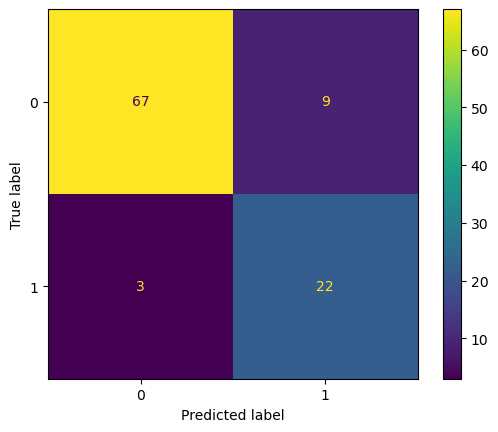

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Get predictions for testing data from model
preds = clf.predict(X_test)

# Create a confusion matrix and display data
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# Display detailed evaluation of model performance
target_names = ['IDH Wildtype', 'IDH Mutated']
print(classification_report(y_test, preds, target_names=target_names))

# Display model accuracy
accuracy = accuracy_score(y_test, preds)
print("Overall Accuracy: ", accuracy)

# Display model f1 score
f1 = f1_score(y_test, preds)
print("Overall f1-score: ", f1)

### This model classifies IDH mutations with 88% accuracy! We see that the model correctly identified 22 of the 25 IDH mutated cases and correctly identified 67 of the 76 IDH wildtype cases. f1-score and other metrics are also reported.

## 1.8 Use Shapley to Determine Which Features are Most Important and How Each Feature is Used to Make Predictions

/Users/james/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


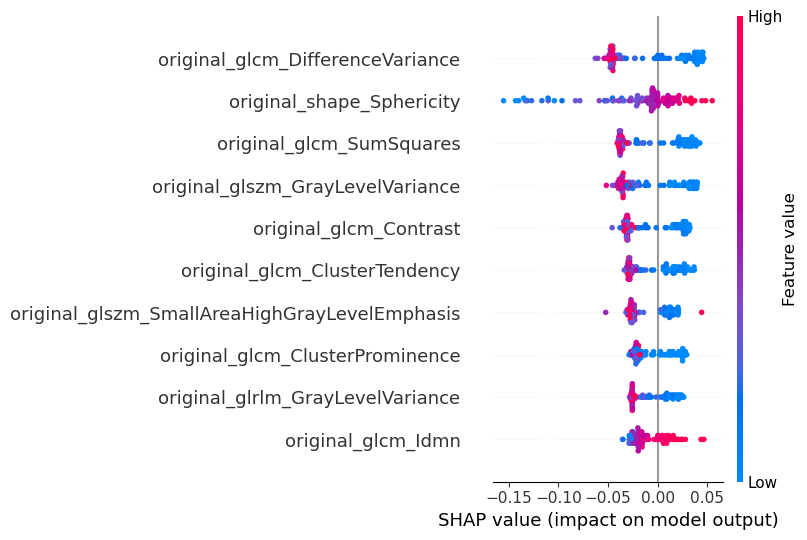

In [8]:
import shap
# Shapley is a tool to explain how each feature is being used
# by the model to make predictions
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
# max_display is set to 10 so that only the ten most important features are displays
shap.summary_plot(shap_values[1], X_test, X.columns, max_display=10)

### Features are listed from most important (top) to least important (bottom). From this model, we can see that "original_glcm_DifferenceVariance" is the most important feature in the model. We can also see that if a tumor has high "original_shape_Sphericity" (pink values) it is more likely to be classified as an IDH mutant tumor. Meanwhile, if the tumor has lower "original_shape_Sphericity” (blue values) it is more likely to be labeled IDH Wildtype. More about these features can be found at the following link:  

https://pyradiomics.readthedocs.io/en/latest/features.html